In [13]:
import os
import warnings
warnings.filterwarnings('ignore')

from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.session import SparkSession

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [14]:
df = pd.read_csv('/Users/fanyang/Documents/musicbox/data/recommender_model01_0116.csv')

In [15]:
df.head(5)

,Unnamed: 0,uid,song_id,comp_play_last_7,comp_play_last_14,comp_play_last_21,comp_play_last_30,comp_play_last_44,freq_P_last_7,freq_P_last_14,freq_P_last_21,freq_P_last_30,freq_P_last_44,freq_D_last_7,freq_D_last_14,freq_D_last_21,freq_D_last_30,freq_D_last_44
0,0,103103073,572912,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,104737814,0,0,0,0,0,0,0,0,0,0,127,0,0,0,0,0
2,2,10919480,277650,2,2,2,2,3,2,2,2,2,3,0,0,0,0,1
3,3,10919480,389413,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0
4,4,10919480,461313,1,2,2,2,2,1,2,2,3,6,0,0,0,0,1


In [16]:
df = df.drop(columns=['Unnamed: 0'])

In [17]:
df.shape

(2005120, 17)

### 1. validate features
#### 1a. remove invalid 'song_id'

In [18]:
df_song = df['song_id'].value_counts()

In [19]:
df_song.shape

(357406,)

In [20]:
df_song.head()

0.0           11431
15249349.0     8480
9950164.0      7987
6468891.0      5102
5237384.0      4903
Name: song_id, dtype: int64

In [21]:
df_song.tail()

3297444      1
829065.0     1
2972729      1
3450501      1
4518649.0    1
Name: song_id, dtype: int64

Text(0.5, 1.0, 'song_id distribution / counts')

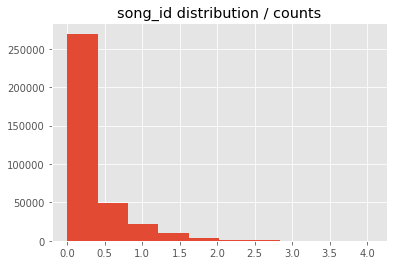

In [22]:
np.log10(df_song).hist().set_title('song_id distribution / counts')

In [23]:
df_song_select = df_song[df_song>10]

In [24]:
df_song_select.shape

(25411,)

In [25]:
#df_select_01 = df.set_index('uid').loc[df_user_select.index].reset_index()

In [26]:
df_select_01 = df.set_index('song_id').loc[df_song_select.index].reset_index()

In [27]:
#df_select_01.shape

In [28]:
# df = df.drop(df[df.score < 50].index)

#df_select_02 = df = df_select_02.drop(df_select_02[df_select_02.song_id==0])

#df[df.Name != 'Alisa']

df_select_01 = df_select_01[df_select_01.song_id != 0]

In [29]:
df_select_01.shape

(1371663, 17)

#### 1b. remove invalid 'uid'

In [30]:
df_user = df['uid'].value_counts()

In [31]:
df_user.shape

(56065,)

In [32]:
df_user.head()

169031835    2223
168451768    1503
168139162    1448
168954949    1425
168479098    1405
Name: uid, dtype: int64

In [33]:
df_user.tail()

168857186    1
168573081    1
168599690    1
168028169    1
17809415     1
Name: uid, dtype: int64

Text(0.5, 1.0, 'uid distribution / counts')

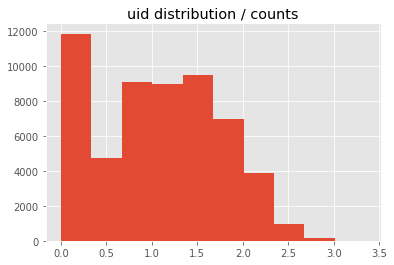

In [34]:
np.log10(df_user).hist().set_title('uid distribution / counts')

In [35]:
df_user_select = df_user[df_user>10]

In [36]:
df_user_select.shape

(30457,)

In [37]:
df_select_02 = df_select_01.set_index('uid').loc[df_user_select.index].reset_index()

In [38]:
df_select_02.shape

(1301133, 17)

### 2. select feature for model

In [39]:
df_select_02.columns

Index(['uid', 'song_id', 'comp_play_last_7', 'comp_play_last_14',
       'comp_play_last_21', 'comp_play_last_30', 'comp_play_last_44',
       'freq_P_last_7', 'freq_P_last_14', 'freq_P_last_21', 'freq_P_last_30',
       'freq_P_last_44', 'freq_D_last_7', 'freq_D_last_14', 'freq_D_last_21',
       'freq_D_last_30', 'freq_D_last_44'],
      dtype='object')

In [40]:
df_feature_select = df_select_02[['comp_play_last_44', 'freq_P_last_44', 'freq_D_last_44']]

In [41]:
df_feature_select = df_feature_select.loc[((df_feature_select.comp_play_last_44) !=0 &(df_feature_select.freq_P_last_44 != 0)) | (df_feature_select.freq_D_last_44 !=0)]

In [42]:
df_feature_select = df_feature_select.loc[((df_feature_select.comp_play_last_44) !=0 &(df_feature_select.freq_P_last_44 != 0)) | (df_feature_select.freq_D_last_44 !=0)]

In [43]:
df_feature_select.shape

(939781, 3)

In [44]:
df_feature_select.describe()

,comp_play_last_44,freq_P_last_44,freq_D_last_44
count,939635.000000,939635.000000,939635.000000
mean,3.203860,5.141486,0.205550
std,8.950775,12.313544,0.458729
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,2.000000,0.000000
75%,3.000000,5.000000,0.000000
max,1629.000000,2049.000000,12.000000


In [45]:
# take log10 of feature distribution
df_feature_select = df_feature_select.apply(lambda x: np.log10(x+1))

In [46]:
df_feature_select.describe()

,comp_play_last_44,freq_P_last_44,freq_D_last_44
count,939635.000000,939635.000000,939635.000000
mean,0.463152,0.589850,0.059584
std,0.292325,0.344403,0.125663
min,0.000000,0.301030,0.000000
25%,0.301030,0.301030,0.000000
50%,0.301030,0.477121,0.000000
75%,0.602060,0.778151,0.000000
max,3.212188,3.311754,1.113943


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126f3fcc0>,
      dtype=object)

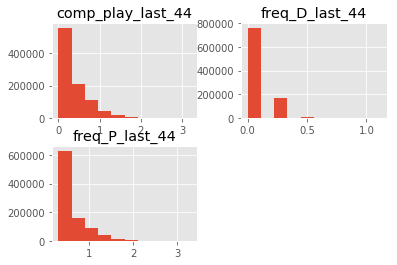

In [47]:
df_feature_select.hist()

In [48]:
#df.isna().sum()
df_feature_select.isna().sum()

comp_play_last_44    146
freq_P_last_44       146
freq_D_last_44       146
dtype: int64

In [49]:
# before drop na
df_feature_select.shape

(939781, 3)

In [50]:
#data2 = data.dropna(axis =0, how = 'any')

df_feature_select2 = df_feature_select.dropna(axis=0, how='any')

In [51]:
df_feature_select2.shape

(939635, 3)

In [52]:
from sklearn import preprocessing

df_feature_select2 = pd.DataFrame(preprocessing.scale(df_feature_select2))

In [53]:
df_feature_select2.columns=['comp_play_last_44_transformed', 'freq_P_last_44_transformed', 'freq_D_last_44_transformed']

In [54]:
df_feature_select2.describe()

,comp_play_last_44_transformed,freq_P_last_44_transformed,freq_D_last_44_transformed
count,9.396350e+05,9.396350e+05,9.396350e+05
mean,4.524109e-13,-1.322555e-13,2.411534e-13
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.584373e+00,-8.386109e-01,-4.741609e-01
25%,-5.545946e-01,-8.386109e-01,-4.741609e-01
50%,-5.545946e-01,-3.273163e-01,-4.741609e-01
75%,4.751836e-01,5.467475e-01,-4.741609e-01
max,9.404037e+00,7.903259e+00,8.390399e+00


### 3. generate utility matrix

In [55]:
df_uitility = df_select_02[['uid','song_id']].copy()

In [56]:
df_uitility.shape

(1301133, 2)

In [57]:
df_uitility[['comp_play_last_44_transformed', 
            'freq_P_last_44_transformed', 
            'freq_D_last_44_transformed']] = df_feature_select2

In [58]:
df_uitility.shape

(1301133, 5)

In [59]:
# compare effects of weight on features

# 'composition_1' : 0.333/0.333/0.333
df_uitility['composition_1'] = 0.333*df_uitility['comp_play_last_44_transformed'] + 0.333*df_uitility['freq_P_last_44_transformed'] + 0.333*df_uitility['freq_D_last_44_transformed']

# 'composition_2' : 0.25/0.25/0.5
df_uitility['composition_2'] = 0.25*df_uitility['comp_play_last_44_transformed'] + 0.25*df_uitility['freq_P_last_44_transformed'] + 0.5*df_uitility['freq_D_last_44_transformed']

# 'composition_3' : 0.1/0.1/0.8
df_uitility['composition_3'] = 0.1*df_uitility['comp_play_last_44_transformed'] + 0.1*df_uitility['freq_P_last_44_transformed'] + 0.8*df_uitility['freq_D_last_44_transformed']

# 'composition_4' : 0.4/0.4/0.2
df_uitility['composition_4'] = 0.4*df_uitility['comp_play_last_44_transformed'] + 0.4*df_uitility['freq_P_last_44_transformed'] + 0.2*df_uitility['freq_D_last_44_transformed']


In [60]:
df_compositions = df_uitility[['composition_1', 'composition_2', 'composition_3', 'composition_4']]

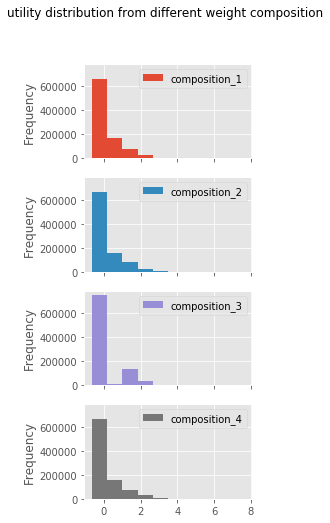

In [61]:
ax = df_compositions.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='utility distribution from different weight composition', figsize = (3,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123eb4780>,
      dtype=object)

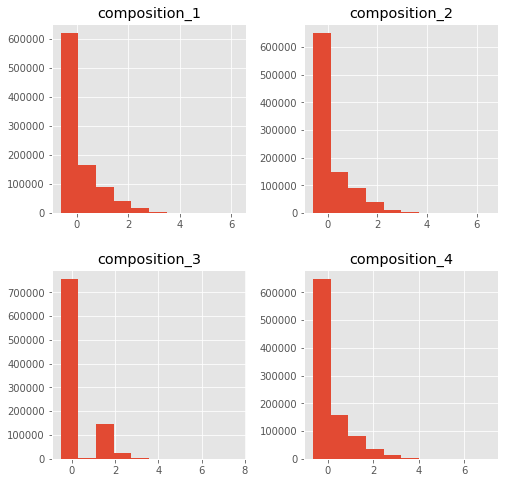

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
df_compositions.hist(ax=ax)

#### based on plots above, I will use composition_1 for segement 'utility' into bins

In [63]:
# use weight_1 composition
(df_uitility['composition_1']).quantile([0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.99])

0.10   -0.621833
0.20   -0.621833
0.25   -0.621833
0.40   -0.451572
0.50   -0.250979
0.60   -0.130177
0.75    0.346144
0.80    0.553262
0.99    2.568896
Name: composition_1, dtype: float64

In [64]:
uitility_min = np.min(df_uitility['composition_1'])
uitility_max = np.max(df_uitility['composition_1'])
print('the minimal of utility is: ', uitility_min, '\n'
     'the maximal of utility is: ', uitility_max)

the minimal of utility is:  -0.6218330137651087 
the maximal of utility is:  6.233439445102739


### 4a. generate implicity ratings that are skewed

In [101]:
# utility_bin_1: segament by using different quantile
# generate ratings that follow left skewed, which is similar to original feature distribution. 

#### 'ratings_1' is follow quantile([0.2, 0.4, 0.6, 0.8])


utility_bin_1 = np.array([uitility_min, -0.621833,
                          -0.451572, -0.130177,
                          0.553262, uitility_max])

df_uitility['ratings_1'] = pd.cut(df_uitility['composition_1'], utility_bin_1, labels=np.arange(1,6))
df_uitility['ratings_1'].value_counts().sort_index()

1         0
2         0
3    193369
4    209390
5    186260
Name: ratings_1, dtype: int64

In [ ]:
(df_uitility['weight_1']).quantile([0.3, 0.5, 0.7, 0.9])

In [102]:
#### 'ratings_2' is follow quantile([0.3, 0.5, 0.7, 0.9])

utility_bin_2 = np.array([uitility_min, -0.621833,
                          -0.250979, 0.175883,
                          1.150384, uitility_max])
df_uitility['ratings_2'] = pd.cut(df_uitility['composition_1'], utility_bin_2, labels=np.arange(1,6))
df_uitility['ratings_2'].value_counts().sort_index()

1         0
2     98401
3    209669
4    186678
5     94271
Name: ratings_2, dtype: int64

In [68]:
(df_uitility['composition_1']).quantile([0.4, 0.6, 0.8, 0.95])

0.40   -0.451572
0.60   -0.130177
0.80    0.553262
0.95    1.647046
Name: composition_1, dtype: float64

In [103]:
#### 'ratings_3' is follow quantile([0.4, 0.6, 0.8, 0.95])

utility_bin_3 = np.array([uitility_min, -0.451572,
                          -0.130177, 0.553262,
                          1.647046, uitility_max])
df_uitility['ratings_3'] = pd.cut(df_uitility['composition_1'], utility_bin_3, labels=np.arange(1,6))
df_uitility['ratings_3'].value_counts().sort_index()

1         0
2    193369
3    209390
4    139307
5     46953
Name: ratings_3, dtype: int64

In [156]:
(df_uitility['composition_1']).quantile([0.55, 0.72, 0.85, 0.95])

0.55   -0.237068
0.72    0.217731
0.85    0.809862
0.95    1.647046
Name: composition_1, dtype: float64

In [157]:
#### 'ratings_4' is follow quantile([0.55, 0.72, 0.85, 0.95])

utility_bin_4 = np.array([uitility_min, -0.237068,
                         0.217731, 0.809862,
                          1.647046, uitility_max])
df_uitility['ratings_4'] = pd.cut(df_uitility['composition_1'], utility_bin_4, labels=np.arange(1,6))
df_uitility['ratings_4'].value_counts().sort_index()

1    174164
2    150870
3    120565
4     96467
5     46953
Name: ratings_4, dtype: int64

Text(0.5, 1.0, 'ratings_4')

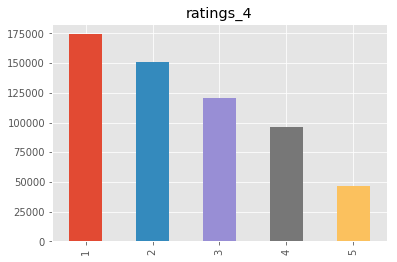

In [158]:
df_uitility['ratings_4'].value_counts().sort_index().plot(kind='bar').set_title('ratings_4')

### 4b. generate implicity ratings that not skewed

In [77]:
step_size = (uitility_max - uitility_min) / 20

utility_bin_5 = np.array([uitility_min,uitility_min+step_size*0.5,
                         uitility_min+step_size*1.5, uitility_min+step_size*4,
                         uitility_min+step_size*8, uitility_max])

df_uitility['ratings_5'] = pd.cut(df_uitility['composition_1'], utility_bin_5, labels=np.arange(1,6))
df_uitility['ratings_5'].value_counts()

3    219841
2    142310
4    132598
1     72746
5     21524
Name: ratings_5, dtype: int64

Text(0.5, 1.0, 'ratings_5')

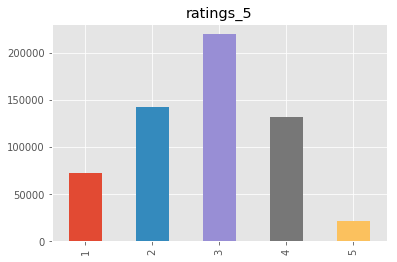

In [78]:
df_uitility['ratings_5'].value_counts().sort_index().plot(kind='bar').set_title('ratings_5')

In [159]:
df_rating_4 = df_uitility[['uid','song_id','ratings_4']]
df_rating_5 = df_uitility[['uid','song_id','ratings_5']]

In [160]:
df_rating_4.isna().sum()

uid               0
song_id         146
ratings_4    712114
dtype: int64

In [81]:
df_rating_5.isna().sum()

uid               0
song_id         146
ratings_5    712114
dtype: int64

In [161]:
df_rating_4 =  df_rating_4.dropna(axis=0, how='any')
df_rating_5 =  df_rating_5.dropna(axis=0, how='any')

In [ ]:
df_rating_4.to_csv("/Users/fanyang/Documents/musicbox/data/musicbox_rating_4_0119.csv")
df_rating_5.to_csv("/Users/fanyang/Documents/musicbox/data/musicbox_rating_5_0119.csv")

In [ ]:

### others ####
6.465753692312682
2.2273256750570636
# seems that bin is not problem

#step_size = (uitility_max - uitility_min) / 15

#utility_bins = np.array([uitility_min,uitility_min+step_size*0.5,
#                         uitility_min+step_size*1, uitility_min+step_size*7,
#                         uitility_min+step_size*7, uitility_max])

In [162]:
df_rating_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589004 entries, 0 to 939631
Data columns (total 3 columns):
uid          589004 non-null int64
song_id      589004 non-null object
ratings_4    589004 non-null category
dtypes: category(1), int64(1), object(1)
memory usage: 14.0+ MB


In [163]:
df_rating_4['ratings_4'] = df_rating_4['ratings_4'].astype(int)
df_rating_4['song_id'] = df_rating_4['song_id'].astype(int)

In [164]:
df_rating_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589004 entries, 0 to 939631
Data columns (total 3 columns):
uid          589004 non-null int64
song_id      589004 non-null int64
ratings_4    589004 non-null int64
dtypes: int64(3)
memory usage: 18.0 MB


### generate utility matrix

In [165]:
df_utility_4 = pd.pivot_table(data=df_rating_4,
                           index='uid',
                           values='ratings_4',
                           columns='song_id',
                           fill_value=0)

In [166]:
df_utility_4.shape

(10810, 23249)

In [167]:
df_utility_4.head(5)

song_id,0,1614,1672,2919,7251,54258,54279,54387,54390,54394,...,24016350,24016907,24016908,24016934,24017105,24017106,24018603,24019502,24021312,24021436
uid,,,,,,,,,,,,,,,,,,,,,
932869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1349791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1809207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4030958,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
df_mat_4 = df_utility_4.as_matrix()

In [169]:
df_mat_4.shape

(10810, 23249)

In [170]:
# compress sparse row matrix

from scipy import sparse
rating_mat_4 = sparse.csr_matrix(df_mat_4)

In [171]:
rating_mat_4

<10810x23249 sparse matrix of type '<class 'numpy.int64'>'
	with 589004 stored elements in Compressed Sparse Row format>

In [172]:
from sklearn.decomposition import NMF

def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    err = nmf.reconstruction_err_
    return W,H,err

# decompose
W,H,err = fit_nmf(rating_mat_4,200)
print(err)
print(W.shape,H.shape)

1858.3166965461949
(10810, 200) (200, 23249)


In [173]:
# reconstruct
rating_mat_fitted_4 = W.dot(H)
errs = np.array((rating_mat_4-rating_mat_fitted_4).flatten()).squeeze()
mask = np.array((rating_mat_4.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print("result based on rating_4")
print(mse)
print(average_abs_err)

result based on rating_4
5.35750278830284
1.8890525962288744


### Do the same way for rating_5

In [96]:
df_rating_5['ratings_5'] = df_rating_5['ratings_5'].astype(int)
df_rating_5['song_id'] = df_rating_5['song_id'].astype(int)

df_utility_5 = pd.pivot_table(data=df_rating_5,
                           index='uid',
                           values='ratings_5',
                           columns='song_id',
                           fill_value=0)

df_mat_5 = df_utility_5.as_matrix()

rating_mat_5 = sparse.csr_matrix(df_mat_5)

W,H,err = fit_nmf(rating_mat_5,200)
print(err)
print(W.shape,H.shape)

1991.7345761934034
(10810, 200) (200, 23249)


In [98]:
rating_mat_fitted_5 = W.dot(H)
errs = np.array((rating_mat_5-rating_mat_fitted_5).flatten()).squeeze()
mask = np.array((rating_mat_5.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print("result based on rating_5")
print(mse)
print(average_abs_err)

result based on rating_5
6.128204526164795
2.131665743833565
